In [1]:
import numpy as np
import yaml
import emcee
import matplotlib.pyplot as plt
import corner

In [2]:
configfile = 'config.yaml'

In [3]:
def hard_prior(theta, params_prior):
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
def gaussian_prior(theta, params_prior):
    mu  = params_prior[:,0]
    std = params_prior[:,1]
    y = (theta - mu) / std
    return -0.5 * np.sum(y * y)

def ln_prior(theta):
    prior_flat = 0.
    prior_gauss = 0.
    
    if(len(config.flat_prior_indices) != 0):
        flat_prior_theta     = theta[config.flat_prior_indices]
        prior_flat    += hard_prior(flat_prior_theta, config.flat_prior_parameters)
    if(len(config.gaussian_prior_indices) != 0):
        gaussian_prior_theta = theta[config.gaussian_prior_indices]
        prior_gauss   += gaussian_prior(gaussian_prior_theta, config.gaussian_prior_parameters)
        
    return prior_flat + prior_gauss

def ln_lkl(theta):
    pass

def ln_posterior(theta):
    return ln_lkl(theta) + ln_prior(theta)

In [4]:
class Config:
    def __init__(self, configfile):
        with open(configfile, "r") as stream:
            config_args = yaml.safe_load(stream)
        self.priors = config_args['priors']
        self.data   = config_args['data']
        self.get_prior_parameters()
        self.get_data()
    
    def get_prior_parameters(self):
        self.gaussian_prior_indices = []
        self.gaussian_prior_parameters = []

        self.flat_prior_indices    = []
        self.flat_prior_parameters = []

        ind = 0
        self.ndim = len(self.priors)
        
        for x in self.priors:
            prior = self.priors[x]
            dist  = prior['dist']
            if(dist=='gauss'):
                self.gaussian_prior_indices.append(ind)
                self.gaussian_prior_parameters.append([prior['loc'], prior['scale']])
            else:
                self.flat_prior_indices.append(ind)
                self.flat_prior_parameters.append([prior['min'], prior['max']])
            ind += 1
        
        self.gaussian_prior_parameters = np.array(self.gaussian_prior_parameters)
        self.flat_prior_parameters = np.array(self.flat_prior_parameters)

    def get_data(self):
        #read in DES measurement
        self.mask = np.genfromtxt(self.data['maskfile'])[:,1]
        self.mask_bool = self.mask.astype(bool)
        
        d = np.genfromtxt(self.data['dvfile'])[:,1]
        ndata = d.shape[0]
        
        cov =np.zeros((ndata,ndata))
        data = np.genfromtxt(self.data['covfile'])
        for i in range(0,data.shape[0]):
            cov[int(data[i,0]),int(data[i,1])] = data[i,2]
            cov[int(data[i,1]),int(data[i,0])] = data[i,2]
            
        self.cov = cov[self.mask_bool][:,self.mask_bool]
        self.dv  = d[self.mask_bool]
        
        self.inv_cov = np.linalg.inv(self.cov)

In [5]:
config = Config(configfile)

In [6]:
# Starting point for the emcee walkers with mean theta0 and rms theta_std

theta0 = 0.5 * (config.flat_prior_parameters[:,1] + config.flat_prior_parameters[:,0])
theta_std = 0.1 * (config.flat_prior_parameters[:,1]-config.flat_prior_parameters[:,0])

In [7]:
ndim, nwalkers = config.ndim, 20
pos0 = theta0 + theta_std * np.random.randn(nwalkers, ndim)

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prior)
sampler.run_mcmc(pos0, 10000);

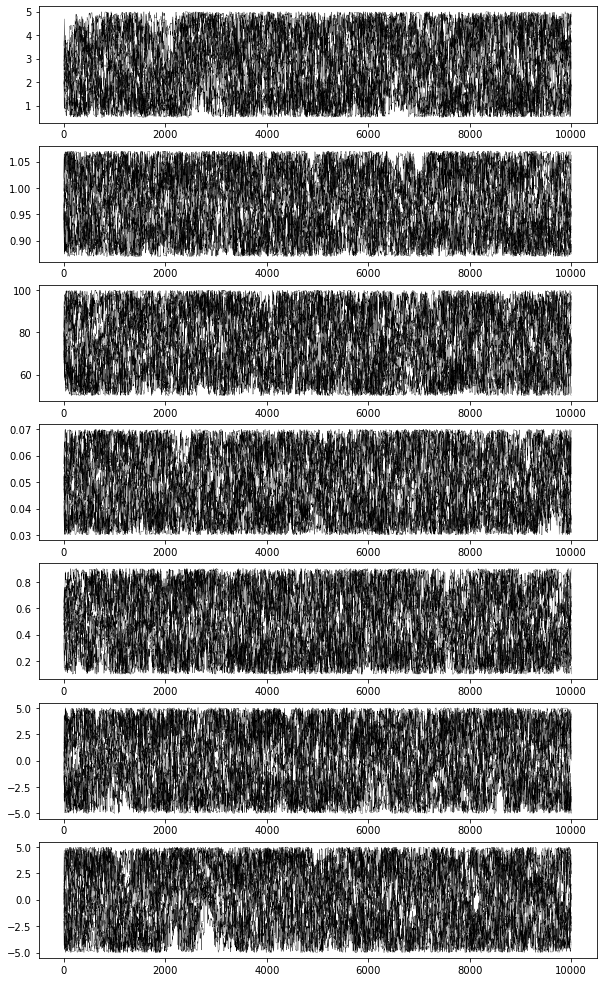

In [9]:
fig, ax = plt.subplots(7,1,figsize=(10,17.5))

for i in range(7):
    ax[i].plot(sampler.chain[:,:,i].T, 'k-', lw=0.3)
    
plt.show()    

In [10]:
samples = sampler.chain[:,1000:].reshape((-1,7))

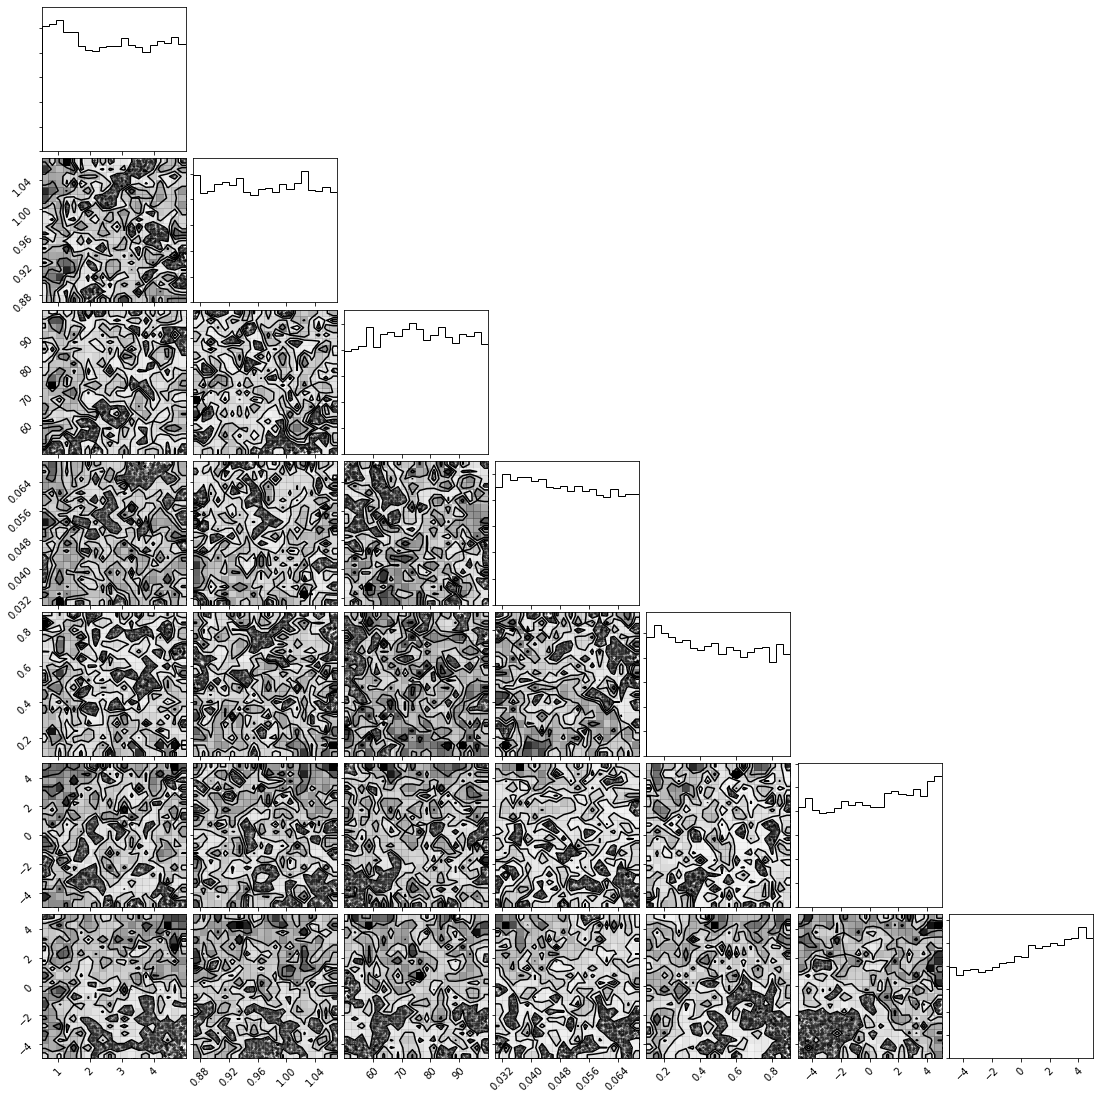

In [11]:
corner.corner(samples)
plt.show()